# Sentence polarity classification

This notebook demonstrates using logistic regression for classication of sentence polarity -- positive vs negative.

It is based on this problem sets(in JP).

We will compare a implemented from scratch model and that provided by sklearn package.
Dataset used here is `sentence polarity dataset v1.0` provided by Bo Pang and Lillian Lee. [To Download Page](http://www.cs.cornell.edu/people/pabo/movie-review-data/)

In [1]:
# -*- coding:latin-1 -*-

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Prepare the data

In [2]:
# Download 
!mkdir data
!rm -rf rt-polaritydata
!curl www.cs.cornell.edu/people/pabo/movie%2Dreview%2Ddata/rt-polaritydata.tar.gz -o ./data/rt-polaritydata.tar.gz
!tar -zxvf ./data/rt-polaritydata.tar.gz

mkdir: data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  476k  100  476k    0     0   181k      0  0:00:02  0:00:02 --:--:--  181k
x rt-polaritydata.README.1.0.txt
x rt-polaritydata/rt-polarity.neg
x rt-polaritydata/rt-polarity.pos


We'll first try to load sentence data and assign 1 to the beginning of positive sentence and 0 to the negative ones.

In [3]:
import random

with open("./rt-polaritydata/rt-polarity.pos", "r") as pos_open:
  pos = pos_open.read().split("\n")
with open("./rt-polaritydata/rt-polarity.neg", "r") as neg_open:
  neg = neg_open.read().split("\n")
  
# tab used instead of space to seperate label and text
pos = ["\t".join(["1", x]) for x in pos]
neg = ["\t".join(["0", x]) for x in neg]
sentiment = pos
sentiment.extend(neg)

random.shuffle(sentiment)

In [4]:
sentiment[:10]

["0\tnair just doesn't have the necessary self-control to guide a loose , poorly structured film through the pitfalls of incoherence and redundancy . ",
 '1\ta finely tuned mood piece , a model of menacing atmosphere . ',
 '1\t " mr . deeds " is suitable summer entertainment that offers escapism without requiring a great deal of thought . ',
 '1\tthe film just might turn on many people to opera , in general , an art form at once visceral and spiritual , wonderfully vulgar and sublimely lofty -- and as emotionally grand as life . ',
 "0\tsuffocated by its fussy script and uptight characters , this musty adaptation is all the more annoying since it's been packaged and sold back to us by hollywood . ",
 "0\tdoesn't amount to much of anything . ",
 '0\tone thing is for sure : this movie does not tell you a whole lot about lily chou-chou . ',
 '1\ta grittily beautiful film that looks , sounds , and feels more like an extended , open-ended poem than a traditionally structured story . ',
 "1\

## Normalizer

In order to further smoothly process the sentences, we need to get rid of the stop words. So let's prepare a model for stop words.

In [5]:
# Two list for stop words:
# 1. http://xpo6.com/list-of-english-stop-words/
# 2*. http://www.textfixer.com/tutorials/common-english-words.txt

import urllib2

class StopWords:
  word_set = urllib2.urlopen("http://www.textfixer.com/tutorials/common-english-words.txt").read().split(",")

  @classmethod
  def is_stop(cls, word):
    return word in cls.word_set

In [6]:
test_list = "hello world and you also".split(" ")
for word in test_list:
  print(word, StopWords.is_stop(word))

('hello', False)
('world', False)
('and', True)
('you', True)
('also', True)


Now that we have the model for stop words. We can start generating features for each sentences. Here's what we're going to do:

- remove punctuation
- remove <> html tags
- remove [] and () tags
- change number to 0: it's rather logical than emotional
- remove 's
- split with space

In [7]:
import re
from collections import Counter
import itertools
from stemming.porter2 import stem
from sklearn.feature_selection import VarianceThreshold

class ReviewFeatures:
  def __init__(self, sentence_list):
    # Convert each sentencen(string) into word list, normalized and stemmed
    self.sentences = [[
      stem(re.sub("\W+", "", word.lower())) 
        for word in self._parse_sentence(sentence) 
        if word and not StopWords.is_stop(word)
      ] for sentence in sentence_list
    ]

  # One hot featurize and take the top feats_cnt counted features
  def generate_feats(self, feats_cnt):
    words_freq = Counter()
    for sentence in self.sentences:
      words_freq.update(sentence)
    feat_names_set = set([tup[0] for tup in words_freq.most_common(feats_cnt)])
    if '' in feat_names_set:
      feat_names_set.remove('')
    sentence_set = [pd.Series(
                      dict(Counter(
                        itertools.ifilterfalse(lambda x: x not in feat_names_set, sentence)
                      )),
                      name=i
                    )
                    for i, sentence in enumerate(self.sentences)]
    self._final_feats = pd.concat(sentence_set, axis = 1).T.fillna(0)
    return self._final_feats

  def featurize_new(self, sentence):
    # Sentence has to be string
    parsed = set(
      stem(re.sub("\W+", "", word.lower())) 
      for word in self._parse_sentence(sentence) 
      if word and not StopWords.is_stop(word)
    )
    return pd.DataFrame({feat : [(feat in parsed) * 1] for feat in self._final_feats.columns})

  # check parsed words (for test)
  def _uniq_words(self):
    uniq_words = set(word for sentence in self.sentences for word in sentence)
    return str(uniq_words)
  
#   PRIVATE
    
  def _parse_sentence(self, sentence):
    # depuncuate
    result = re.sub("[,\.:;\?!`-]+", " ", sentence)
    # rip <>tag
    result = re.sub("((?:<\w+>)|(?:<\/\w+>))", "", result)
    # rip [], () contents
    result = re.sub("((?:\[.+\])|(?:\(.+\)))", "", result)
    # rip number
    result = re.sub("(?:\w*[0-9\/\.]+)+", "0", result)
    # rip 's ...
    result = re.sub("(?:'\w+)+", "", result)
    # rip 
    return result.split(" ")

  def __str__(self):
    return(str(self.sentences))

In [8]:
data = [row.split("\t") for row in sentiment]
labels = pd.Series([(int(row[0]) > 0) * 1 for row in data])
sentences = [row[1] for row in data]

In [9]:
%%time
feat_gen = ReviewFeatures(sentences)

CPU times: user 13.8 s, sys: 786 ms, total: 14.6 s
Wall time: 23.2 s


In [10]:
df = feat_gen.generate_feats(1000)
print(df.head())

     0   0s  0th  abil  abov  absolut  absorb  absurd  accomplish  achiev  \
0  0.0  0.0  0.0   0.0   0.0      0.0     0.0     0.0         0.0     0.0   
1  0.0  0.0  0.0   0.0   0.0      0.0     0.0     0.0         0.0     0.0   
2  0.0  0.0  0.0   0.0   0.0      0.0     0.0     0.0         0.0     0.0   
3  0.0  0.0  0.0   0.0   0.0      0.0     0.0     0.0         0.0     0.0   
4  0.0  0.0  0.0   0.0   0.0      0.0     0.0     0.0         0.0     0.0   

     ...     writer  written  wrong    x    y   ya  year  yes  young  yourself  
0    ...        0.0      0.0    0.0  0.0  0.0  0.0   0.0  0.0    0.0       0.0  
1    ...        0.0      0.0    0.0  0.0  0.0  0.0   0.0  0.0    0.0       0.0  
2    ...        0.0      0.0    0.0  0.0  0.0  0.0   0.0  0.0    0.0       0.0  
3    ...        0.0      0.0    0.0  0.0  0.0  0.0   0.0  0.0    0.0       0.0  
4    ...        0.0      0.0    0.0  0.0  0.0  0.0   0.0  0.0    0.0       0.0  

[5 rows x 999 columns]


With features generated, now we can learn the logistic models and use it to predict polarities.
Here's some recap on logistic regression.

## Logistic classifier from scratch

First we have the logistic function:

$$ f(x)=\frac{1}{( 1 + e^{x})}$$

When used in regression:

$$P(Y=1|X) = \frac{1}{1 + exp(\beta_0 + \Sigma_{i=1}^n \beta_ix_i)}$$

$$P(Y=0|X) = \frac{exp(\beta_0 + \Sigma_{i=1}^n \beta_ix_i)}{1 + exp(\beta_0 + \Sigma_{i=1}^n \beta_ix_i)}$$

With the following property:

$$\frac{P(Y=0|X)}{P(Y=1|X)} = exp(\beta_0 + \Sigma_{i=1}^n \beta_ix_i)$$

$y_i$'s probability density function:

$$p(Y|X, \beta)=f(X, \beta)^{Y}(1 - f(X, \beta))^{1-Y}$$

when transformed into log likelihood:

$$log(L(\beta|X, Y)) = Ylogf(X, \beta) + (1-Y)log(1-f(X, \beta))$$

which could be rewrite as:

$$log(L(\beta|X, Y)) = logf(X, \beta) + (1-Y)\Sigma x_i\beta_i $$

when using stochastic gradient descent, the gradient for ith feature is:

$$\frac{\partial}{\partial\beta_i}log(L(\beta|X, Y))=x_i(Y-f(X))$$

In [11]:
# Build from scratch, duck type sklearn
class LogisticClassifier:
  def fit(self, x, y, seed=0, use_stochastic=False, **kwargs):
    np.random.seed(seed)
    beta_0 = np.random.random((x.shape[1],))
    traget_fn = lambda beta: self._logistic_log_likelihood(x.values, y.values, beta)
    if not use_stochastic:
      gradient_fn = lambda beta: self._logistic_log_gradient(x.values, y.values, beta)
      self._minimize_batch(traget_fn, gradient_fn, beta_0)
    else:
      gradient_fn = self._logistic_log_gradient
      if kwargs:
        self._minimize_batch_stochastic(traget_fn, gradient_fn, x.values, y.values, beta_0, **kwargs)
      else:
        self._minimize_batch_stochastic(traget_fn, gradient_fn, x.values, y.values, beta_0)

  def predict(self, x, threshold=0.5):
    return (self.predict_proba(x) > threshold) * 1
  
  def predict_proba(self, x):
    return self._logistic(np.dot(self.coef_.reshape(1, -1), x.values.T)).reshape(-1,)

  # PRIVATE

  def _logistic(self, x):
    return 1.0 / (1 + np.exp(-x))

  def _logistic_log_likelihood(self, x, y, beta):
    return -1 * sum(
      np.log(1 - y_i + 2 * (y_i - 0.5) * self._logistic(np.dot(x_i, beta)))
      for x_i, y_i in zip(x, y)
    ) / x.shape[0]

  def _logistic_log_gradient(self, x, y, beta):
    y_ = np.array(y)
    y_ = y_.reshape(1, -1)
    beta_ = beta.reshape(1, -1)
    return (-1 * np.dot((y_ - self._logistic(np.dot(beta_, x.T))), x)).reshape(-1,) / x.shape[0]

  def _minimize_batch(self, target_fn, gradient_fn, beta_0, tolerance=0.0001):
    """use gradient descent to find beta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    beta = beta_0.reshape(-1,)
    target_fn = target_fn               # safe version of target_fn
    value = target_fn(beta)                # value we're minimizing

    while True:
      gradient = gradient_fn(beta)

      next_betas = np.array([beta - step_size * gradient for step_size in step_sizes])
      # choose the one that minimizes the error function
      next_beta = min(next_betas, key=target_fn)
      next_value = target_fn(next_beta)
      # stop if we're "converging"
      if abs(value - next_value) < tolerance:
        self.coef_ = beta.reshape(-1,)
        break
      else:
        beta, value = next_beta, next_value  

  def _random_order(self, size):
    result = list(range(size))
    np.random.shuffle(result)
    return result
        
  def _minimize_batch_stochastic(self, target_fn, gradient_fn, 
                                 x, y, beta_0, alpha_0=0.01, eta=0.9,
                                 batch_cnt=100, max_iters=20, theshold=0.0001, test=True):

    beta = beta_0.reshape(-1,)                     # initial guess
    alpha = alpha_0                             # initial step size
    min_beta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0
    batch_size = int(x.shape[0] / batch_cnt) + 1
    batch_cnt = int(x.shape[0] / batch_size)

    test = 0
    while iterations_with_no_improvement < max_iters:
      value = target_fn(beta)
      if test:
        print(value, min_value, alpha)
        test += 1
        if test >= 20:
          break
      if value + theshold < min_value:
        min_beta, min_value = beta, value
        iterations_with_no_improvement = 0
        
      else:
        iterations_with_no_improvement += 1
        alpha *= eta
        beta = min_beta

      ran_order = self._random_order(x.shape[0])
      for i in range(batch_cnt):
        indices = ran_order[i * batch_size : (i+1) * batch_size]
        gradient = gradient_fn(x[indices], y[indices], beta)
        beta -= alpha * gradient
    self.coef_ = beta.reshape(-1,)

In [12]:
%%time
# Fit data
scratch_classifier = LogisticClassifier()
args = { 'batch_cnt' : 200, 'max_iters' : 20, 'alpha_0' : 10, 'eta' : 0.9, 'theshold' : 0.0001 }
scratch_classifier.fit(df, labels, 0, True, **args)

CPU times: user 32.9 s, sys: 1.28 s, total: 34.2 s
Wall time: 36.3 s


In [13]:
# Use scikit-learn, pass
def predict_new_sentence(sentence):
  new_df = feat_gen.featurize_new(sentence)
  return scratch_classifier.predict_proba(new_df)

In [14]:
new_sentence = "As most of you are aware I have not been a huge fan of the latest X- Men outings, but THIS WAS AWESOME!"
predict_new_sentence(new_sentence)

array([ 0.78232565])

Now let's see the top 10 features with highest coef (positve features) , and the top 10 with lowest (negative features).

In [15]:
scratch_feat_weights = pd.Series(data=scratch_classifier.coef_, index=df.columns)
scratch_feat_weights.sort_values(inplace=True)
print(scratch_feat_weights.tail(10))
print(scratch_feat_weights.head(10))

reflect     2.396442
gentl       2.439123
skin        2.585510
examin      2.740212
realist     2.917448
delic       3.169452
rivet       3.535377
unexpect    3.612126
refresh     4.015643
engross     4.250821
dtype: float64
unfunni   -4.181769
routin    -3.437380
lame      -3.410728
disguis   -3.356337
bore      -3.118536
generic   -2.911477
dull      -2.896264
strain    -2.860844
mediocr   -2.742508
suppos    -2.643154
dtype: float64


The negative features seem to be reasonable, the positive ones are rather inaccurate.

Let's combine predicted data with the real ones.

In [16]:
scratch_predicted_labels = scratch_classifier.predict(df)
scratch_predicted_proba = scratch_classifier.predict_proba(df)
result = pd.DataFrame({
  "real" : labels, 
  "predicted" : scratch_predicted_labels, 
  "probability" : scratch_predicted_proba
})
result.head(10)

,predicted,probability,real
0,0,0.031362,0
1,1,0.966480,1
2,1,0.956005,1
3,1,0.943379,1
4,0,0.361746,0
5,0,0.113282,0
6,0,0.116921,0
7,1,0.965289,1
8,1,0.836224,1
9,0,0.364210,0


In [17]:
def accuracy(y_true, y_pred):
  return 1.0 * sum((y_true + y_pred) != 1) / len(y_true)
def precision(y_true, y_pred):
  return 1.0 * sum(y_true * y_pred) / sum(y_pred)
def recall(y_true, y_pred):
  return 1.0 * sum(y_true * y_pred) / sum(y_true)
def f1_score(y_true, y_pred):
  precision_score = precision(y_true, y_pred)
  recall_score = recall(y_true, y_pred)
  return 2.0 * precision_score * recall_score / (precision_score + recall_score)

print("Accuracy: %.3f" % (accuracy(y_true=labels, y_pred=scratch_predicted_labels)))
print("Precission: %.3f" % (precision(y_true=labels, y_pred=scratch_predicted_labels)))
print("Recall: %.3f" % (recall(y_true=labels, y_pred=scratch_predicted_labels)))
print("F1 score: %.3f" % (f1_score(y_true=labels, y_pred=scratch_predicted_labels)))

Accuracy: 0.784
Precission: 0.777
Recall: 0.795
F1 score: 0.786


We can see that the scores here are similar. This might happen when there's same amount of samples from each of the 2 classes. Precission and recall could be pretty skewed when classes are unbalanced. This is when we need F1 score.

In order to avoid overfitting, we should try to use cross validation. Here we're going to do it with 5 folds.

In [18]:
%%time
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
args = { 'batch_cnt' : 200, 'max_iters' : 20, 'alpha_0' : 10, 'eta' : 0.9, 'theshold' : 0.0001 }

scratch_cv_proba = pd.Series(np.zeros(shape=(df.shape[0])))
for train, test in kf.split(np.array(df)):
  scratch_classifier.fit(df.iloc[train, :], labels[train], 0, True, **args);
  scratch_predicted_labels = scratch_classifier.predict(df.iloc[test, :])
  scratch_cv_proba.iloc[test] = scratch_classifier.predict_proba(df.iloc[test, :])
  print("Acc: %.3f\tPrec: %.3f\tRecall: %.3f\tF1_score:%.3f" % (
    accuracy(y_true=labels[test], y_pred=scratch_predicted_labels),
    precision(y_true=labels[test], y_pred=scratch_predicted_labels),
    recall(y_true=labels[test], y_pred=scratch_predicted_labels),
    f1_score(y_true=labels[test], y_pred=scratch_predicted_labels)
  ))

"CV Result summary"
print("Acc: %.3f\tPrec: %.3f\tRecall: %.3f\tF1_score:%.3f" % (
  accuracy(y_true=labels, y_pred=(scratch_cv_proba >= 0.5) * 1),
  precision(y_true=labels, y_pred=(scratch_cv_proba >= 0.5) * 1),
  recall(y_true=labels, y_pred=(scratch_cv_proba >= 0.5) * 1),
  f1_score(y_true=labels, y_pred=(scratch_cv_proba >= 0.5) * 1)
))

Acc: 0.730	Prec: 0.737	Recall: 0.738	F1_score:0.738
Acc: 0.707	Prec: 0.702	Recall: 0.714	F1_score:0.708
Acc: 0.715	Prec: 0.700	Recall: 0.740	F1_score:0.719
Acc: 0.718	Prec: 0.708	Recall: 0.733	F1_score:0.720
Acc: 0.726	Prec: 0.724	Recall: 0.729	F1_score:0.727
Acc: 0.716	Prec: 0.707	Recall: 0.737	F1_score:0.722
CPU times: user 2min 8s, sys: 4.79 s, total: 2min 13s
Wall time: 2min 20s


By shifting the decision value, we could acquire a precision - recall graph.

In [19]:
determination_th = np.arange(0, 1, 0.01)
prec_list = [precision(y_true=labels, y_pred=(scratch_cv_proba >= th) * 1) for th in determination_th]
recall_list = [recall(y_true=labels, y_pred=(scratch_cv_proba >= th) * 1) for th in determination_th]

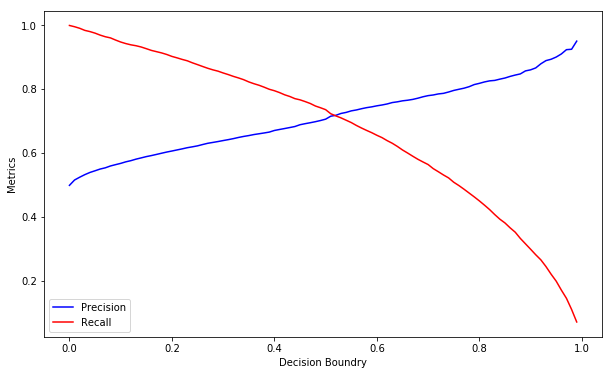

In [20]:
mpl.rcParams["figure.figsize"] = (10, 6)
prec_line = plt.plot(determination_th, prec_list, color='b', label="Precision");
recall_line = plt.plot(determination_th, recall_list, color='r', label="Recall");
plt.xlabel("Decision Boundry");
plt.ylabel("Metrics");
plt.legend();

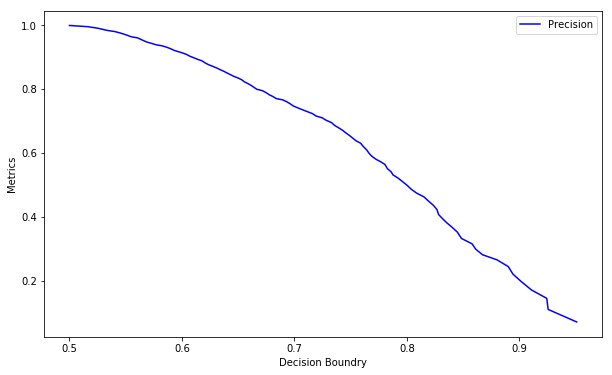

In [21]:
mpl.rcParams["figure.figsize"] = (10, 6)
prec_recal_line = plt.plot(prec_list, recall_list, color='b', label="Precision");
plt.xlabel("Decision Boundry");
plt.ylabel("Metrics");
plt.legend();

## LogisticRegression from Sklearn

Let's try to use pacages provided by sklearn and see how the model is different. Since it is expected to be much faster, let's do a grid search to optimize the hyper-parameter C used for regulation.

In [22]:
%%time
# Use scikit-learn logistic model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {
  'C' : [1e3, 1e2, 10, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
}

predictor = LogisticRegression(
  penalty = "l2",
  C = 1e10
)
searcher = GridSearchCV(
  estimator=predictor,
  param_grid=params,
  scoring='accuracy',
  cv=5,
)
searcher.fit(df.values, labels.values)
(searcher.best_score_, searcher.best_params_)

CPU times: user 9.88 s, sys: 2.15 s, total: 12 s
Wall time: 12.3 s


In [23]:
list(zip(searcher.cv_results_['mean_test_score'], searcher.cv_results_['params']))
(searcher.best_score_, searcher.best_params_)

[(0.72064891222805705, {'C': 1000.0}),
 (0.72046136534133531, {'C': 100.0}),
 (0.72177419354838712, {'C': 10}),
 (0.72599399849962487, {'C': 1}),
 (0.72946361590397601, {'C': 0.5}),
 (0.72702550637659413, {'C': 0.1}),
 (0.72515003750937734, {'C': 0.05}),
 (0.70761440360090022, {'C': 0.01}),
 (0.69804951237809454, {'C': 0.005}),
 (0.67666916729182292, {'C': 0.001}),
 (0.67469992498124531, {'C': 0.0005})]

(0.72946361590397601, {'C': 0.5})

It seems that C=0.5 is the best setting. Let's check the metrics with 5-fold cross validation as well.

In [24]:
predictor = LogisticRegression(
  penalty = "l2",
  C = 0.5
)

predictor.fit(df, labels)
predicted_labels = predictor.predict(df)
predicted_proba = predictor.predict_proba(df)
result = pd.DataFrame({
  "real" : labels, 
  "predicted" : predicted_labels, 
  "probability" : [prob[1] for prob in predicted_proba]
})
result.head(10)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

,predicted,probability,real
0,0,0.088469,0
1,1,0.907255,1
2,1,0.945093,1
3,1,0.905961,1
4,0,0.350828,0
5,0,0.134789,0
6,0,0.165172,0
7,1,0.911506,1
8,1,0.775141,1
9,0,0.433450,0


In [25]:
from sklearn import metrics
kwargs = {"y_true" : labels, "y_pred" : predicted_labels }
print("Accuracy: %.3f" % (metrics.accuracy_score(**kwargs)))
print("Precission: %.3f" % (metrics.precision_score(**kwargs)))
print("Recall: %.3f" % (metrics.recall_score(**kwargs)))
print("F1 score: %.3f" % (metrics.f1_score(**kwargs)))

Accuracy: 0.784
Precission: 0.788
Recall: 0.777
F1 score: 0.782


In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

cv_proba = pd.Series(np.zeros(shape=(df.shape[0])))
for train, test in kf.split(np.array(df)):
  _ = predictor.fit(df.iloc[train, :], labels[train]);
  predicted_labels = predictor.predict(df.iloc[test, :])
  cv_proba.iloc[test] = [x[1] for x in predictor.predict_proba(df.iloc[test, :])]
  print("Acc: %.3f\tPrec: %.3f\tRecall: %.3f\tF1_score:%.3f" % (
    metrics.accuracy_score(y_true=labels[test], y_pred=predicted_labels),
    metrics.precision_score(y_true=labels[test], y_pred=predicted_labels),
    metrics.recall_score(y_true=labels[test], y_pred=predicted_labels),
    metrics.f1_score(y_true=labels[test], y_pred=predicted_labels)
  ))

"CV Result summary"
print("Acc: %.3f\tPrec: %.3f\tRecall: %.3f\tF1_score:%.3f" % (
  metrics.accuracy_score(y_true=labels, y_pred=(cv_proba >= 0.5) * 1),
  metrics.precision_score(y_true=labels, y_pred=(cv_proba >= 0.5) * 1),
  metrics.recall_score(y_true=labels, y_pred=(cv_proba >= 0.5) * 1),
  metrics.f1_score(y_true=labels, y_pred=(cv_proba >= 0.5) * 1)
))


Acc: 0.729	Prec: 0.744	Recall: 0.722	F1_score:0.733
Acc: 0.725	Prec: 0.729	Recall: 0.713	F1_score:0.721
Acc: 0.728	Prec: 0.725	Recall: 0.721	F1_score:0.723
Acc: 0.732	Prec: 0.729	Recall: 0.730	F1_score:0.730
Acc: 0.735	Prec: 0.739	Recall: 0.729	F1_score:0.734


'CV Result summary'

Acc: 0.730	Prec: 0.733	Recall: 0.723	F1_score:0.728


In [27]:
determination_th = np.arange(0, 1, 0.01)
prec_list = [metrics.precision_score(y_true=labels, y_pred=(cv_proba >= th) * 1) for th in determination_th]
recall_list = [metrics.recall_score(y_true=labels, y_pred=(cv_proba >= th) * 1) for th in determination_th]

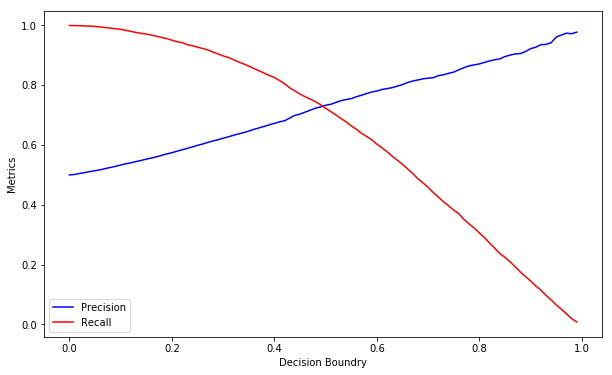

In [28]:
mpl.rcParams["figure.figsize"] = (10, 6)
prec_line = plt.plot(determination_th, prec_list, color='b', label="Precision");
recall_line = plt.plot(determination_th, recall_list, color='r', label="Recall");
plt.xlabel("Decision Boundry");
plt.ylabel("Metrics");
plt.legend();

# Conlusion

We can see that though the accuracy is not quite different, however calculation of the from_scratch model is much longer than sklearn's.